# PyTorchを使う
PyTorchは深層学習フレームワークの1つ。1からプログラムをするのに比べ簡単で、かつGPUを利用した計算ができる。ほかにもTensorFlow, Chainerなど多くのフレームワークがある。本格的なディープラーニングでは、事実上、このいずれかを利用することになる。

使うときには以下のようにする。

In [1]:
import torch

## 多クラスロジスティック回帰

PyTorchでは、変数は Tensor という型に入れる。numpyのデータからはfrom_numpy関数で変換できる。

In [2]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
M = iris.target_names.size # クラス(アヤメの種類)の数
D = iris.data.shape[1] # 特徴量の数
X = torch.from_numpy(iris.data).float()
C = torch.from_numpy(iris.target)

In [3]:
X_train = X[0::2] # 偶数番目
X_test = X[1::2] # 奇数番目
C_train = C[0::2]
C_test = C[1::2]

多クラスロジスティック回帰は、
<span id="multiclasslogistic">
\begin{align*}
z_m&=\boldsymbol{w_m}^\top\boldsymbol{x} \\
y_m&=\text{softmax}(z_m)=\frac{\exp(z_m)}{\sum_j \exp(z_j)}
\end{align*}
</span>
だった。まず $\boldsymbol{x}$ を $\boldsymbol{W}$ で線形変換して $\boldsymbol{z}$ を得る。次に $\boldsymbol{z}$ を softmax 関数に通して $\boldsymbol{y}$ を得るという手順であった。

PyTorchでは、このようなベクトル(テンソル)の変換の繰り返しでモデルを定義する。線形変換には Linear, 対数 softmax には LogSoftmax というモジュールをモデルに順番に追加する。

In [4]:
model = torch.nn.Sequential()
model.add_module("linear", torch.nn.Linear(in_features=D,out_features=M))
model.add_module("softmax", torch.nn.LogSoftmax(dim=1))

損失関数は、自分で定義しなくとも最初からいろいろ用意されている。ロジスティック回帰の損失関数は負の対数尤度 (Negative Log Likelihood) なので NLLLoss という関数が使える。

In [5]:
crossEntropyLoss = torch.nn.NLLLoss() # 損失関数

PyTorchを使ったモデル学習の基本は次の通りである。

まず、forward (前向き) 計算を行う。入力から出力への向きのことを前向きと呼ぶ。ここでは $\boldsymbol{x}$ から $\boldsymbol{z}$ 、$\boldsymbol{z}$ から $\boldsymbol{y}$ の計算である。上で定義した model 関数を使うと、出力の計算(=forward計算)が行える。

出力がわかると、教師データとの関係から損失が計算できる。次に損失を計算する。上で定義した crossEntropyLoss 関数に、出力と教師データを与えると計算してくれる。

次に、最小化したい値(ここでは loss)に対してbackward (後向き) 計算を行う。ここで計算されているのは誤差と呼ばれる値である。多クラスロジスティック回帰の場合には、クラス $m$ の教師信号との誤差は $y_m-t_m$ である。第2回の課題(2)でやったように、 $E$ の勾配は
$\sum_k (y_{km}-t_{km})\boldsymbol{x}$ となる。つまり、誤差と入力の積によって勾配が計算できる。PyTorch の backward 関数は、各層の誤差を計算するのと同時に、その層への入力との積から勾配 grad を計算し、パラメータの中に保存する。なお計算した勾配は蓄積される仕様なので、backward計算の前にゼロクリアしている。

後は今までと同じように、勾配に学習係数をかけた値をパラメータから引けば1回の更新が終了する。

In [6]:
learning_rate = 0.1
step_num = 10000

for i in range(step_num):
    Y = model(X_train) # forward計算
    loss = crossEntropyLoss(Y, C_train) # 損失の計算
    W, b = model.parameters()
    if W.grad is not None:
        W.grad.data.zero_()
        b.grad.data.zero_()

    loss.backward() # backward計算
    # 勾配法
    W.data -= learning_rate * W.grad.data
    b.data -= learning_rate * b.grad.data

学習の済んだモデルにテストデータの入力を入れると各クラスの対数確率が得られる。対数確率が最大のクラスが認識結果となる。

In [7]:
def accuracy(model,X,C):
    Y = model(X)
    result = np.array([np.argmax(y) for y in Y.detach().numpy()])
    answer = C.detach().numpy()
    return np.sum(np.equal(result, answer)) / C.shape[0]

In [8]:
accuracy(model,X_test,C_test)

0.9466666666666667

# 手書き数字の認識

アヤメの分類よりももう少しだけ本格的な問題を解いてみる。[MNIST](https://en.wikipedia.org/wiki/MNIST_database)は0から9までの手書き数字画像のデータベースである。これを使って、多クラスロジスティック回帰モデルで手書き数字の認識をやってみよう。

In [9]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets import fetch_mldata
import os
import urllib.request

# プロキシ設定 (大学の中でやるときだけ)
proxy = urllib.request.ProxyHandler({'http': 'http://proxya.cc.utsunomiya-u.ac.jp:8080',
                                     'https': 'http://proxya.cc.utsunomiya-u.ac.jp:8080'})
opener = urllib.request.build_opener(proxy)
urllib.request.install_opener(opener)
# プロキシ設定 ここまで

if not os.path.exists("mldata"):
    os.makedirs("mldata")
mnist_save_path = os.path.join("mldata","mnist-original.mat")
if not os.path.exists(mnist_save_path):
    mnist_url = urllib.request.urlopen("http://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat")
    with open(mnist_save_path, "wb") as matlab_file:
        copyfileobj(mnist_url, matlab_file)

mnist = fetch_mldata("MNIST original",data_home=".")

mnist.data には0から255までの画素値、 mnist.target にはどの数字かを表す数値が入っている。まずXを最大値1に正規化する。

In [10]:
X = mnist.data / 255.0
C = mnist.target.astype(np.long)
X.shape

(70000, 784)

データ数は全部で70000個、特徴量の数は画素数($28\times28=784$)である。

以下のコードで、データの1つを描画できる。Xの添字を適当に変えて、MNISTがどのようなデータなのか眺めておこう。

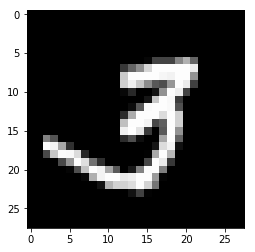

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X[23450].reshape(28,28), cmap='gray')

In [12]:
M = 10 # 数字の数
D = 28 * 28 # 特徴量の数

90%のデータで訓練、残り10%でテストする。

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, C_train, C_test = train_test_split(X, C, test_size=0.1, random_state=0)

モデル定義はirisの時と同じ。

In [14]:
model = torch.nn.Sequential()
model.add_module("linear", torch.nn.Linear(in_features=D,out_features=M))
model.add_module("softmax", torch.nn.LogSoftmax(dim=1))

学習部分については関数化しておこう。

In [15]:
def train(model, X, C, learning_rate=0.5, step_num=100):
    for i in range(step_num):
        Y = model(X) # forward計算
        loss = crossEntropyLoss(Y, C) # 損失の計算
        W, b = model.parameters()
        if W.grad is not None:
            W.grad.data.zero_()
            b.grad.data.zero_()

        loss.backward() # backward計算
        # 勾配法
        W.data -= learning_rate * W.grad.data
        b.data -= learning_rate * b.grad.data
        print("epoch {}: loss = {}".format(i+1,loss))

では学習してみよう。

In [16]:
X_train_t=torch.from_numpy(X_train).float()
C_train_t=torch.from_numpy(C_train)
train(model,X_train_t,C_train_t,step_num=200)

epoch 1: loss = 2.2858643531799316
epoch 2: loss = 1.8229169845581055
epoch 3: loss = 1.5158662796020508
epoch 4: loss = 1.3045480251312256
epoch 5: loss = 1.1576627492904663
epoch 6: loss = 1.0474191904067993
epoch 7: loss = 0.965282678604126
epoch 8: loss = 0.9022248387336731
epoch 9: loss = 0.8522015810012817
epoch 10: loss = 0.8114147782325745
epoch 11: loss = 0.7773453593254089
epoch 12: loss = 0.7483292818069458
epoch 13: loss = 0.7232434153556824
epoch 14: loss = 0.7013031244277954
epoch 15: loss = 0.681917667388916
epoch 16: loss = 0.6646405458450317
epoch 17: loss = 0.6491319537162781
epoch 18: loss = 0.6351189017295837
epoch 19: loss = 0.6223824620246887
epoch 20: loss = 0.6107408404350281
epoch 21: loss = 0.6000545620918274
epoch 22: loss = 0.5902044773101807
epoch 23: loss = 0.5810917615890503
epoch 24: loss = 0.5726215839385986
epoch 25: loss = 0.5647355914115906
epoch 26: loss = 0.5573670864105225
epoch 27: loss = 0.5504589676856995
epoch 28: loss = 0.5439701676368713
epo

正解率を調べる。

In [17]:
X_test_t=torch.from_numpy(X_test).float()
C_test_t=torch.from_numpy(C_test)
accuracy(model,X_test_t,C_test_t)

0.9035714285714286

## ミニバッチ学習
ここまでは、全データで一挙に重みを更新した。これをバッチ学習という。これに対し、深層学習の世界では、全データをいくつかのミニバッチに分割して勾配降下法を実行するSGD(確率的勾配降下法)、またの名をミニバッチ学習という学習方法がよく使われる。この方法は、収束が速く、局所最小値にはまる危険が少ない特長を持っている。

PyTorchでは、DataLoaderという機能を使うとデータを自動的にミニバッチに分割してくれる。この機能を使うために、まずMNIST用にデータセットを定義しておく。

In [18]:
from torch.utils.data import Dataset, DataLoader

class MNISTTrainDataSet(Dataset):
    def __len__(self):
        return X_train.shape[0]
    
    def __getitem__(self, idx):
        return X_train[idx].astype('float'), C_train[idx]

今回のDataLoaderでは、バッチサイズを50とする。つまり、70000個のデータを50個ずつに分割し、それぞれで勾配降下法によりパラメータを更新する。これを全データに対して行う。全データを1回なめることを1エポックという。

In [19]:
mnist = MNISTTrainDataSet()
train_loader = DataLoader(dataset=mnist,batch_size=50,shuffle=True)

モデルは上と同じ。

In [20]:
model = torch.nn.Sequential()
model.add_module("linear", torch.nn.Linear(in_features=D,out_features=M))
model.add_module("softmax", torch.nn.LogSoftmax(dim=1))

学習部分は以下のようになる。

In [21]:
def train(model, learning_rate=0.5, num_epochs=100):
    for epoch in range(num_epochs):
        for X, C in train_loader:
            X = X.float() # DataLoaderはデータをdouble型で渡すので、後の処理のためにfloat型に変換
            Y = model(X) # forward計算
            loss = crossEntropyLoss(Y, C) # 損失の計算
            W, b = model.parameters()
            if W.grad is not None:
                W.grad.data.zero_()
                b.grad.data.zero_()

            loss.backward() # backward計算
            # 勾配法
            W.data -= learning_rate * W.grad.data
            b.data -= learning_rate * b.grad.data
        Y = model(X_train_t)
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, crossEntropyLoss(Y, C_train_t)))

In [22]:
train(model,learning_rate=0.1)

Epoch [1/100], Loss: 0.3389
Epoch [2/100], Loss: 0.3083
Epoch [3/100], Loss: 0.2926
Epoch [4/100], Loss: 0.2854
Epoch [5/100], Loss: 0.2796
Epoch [6/100], Loss: 0.2781
Epoch [7/100], Loss: 0.2720
Epoch [8/100], Loss: 0.2689
Epoch [9/100], Loss: 0.2658
Epoch [10/100], Loss: 0.2626
Epoch [11/100], Loss: 0.2647
Epoch [12/100], Loss: 0.2610
Epoch [13/100], Loss: 0.2603
Epoch [14/100], Loss: 0.2584
Epoch [15/100], Loss: 0.2561
Epoch [16/100], Loss: 0.2563
Epoch [17/100], Loss: 0.2552
Epoch [18/100], Loss: 0.2540
Epoch [19/100], Loss: 0.2545
Epoch [20/100], Loss: 0.2526
Epoch [21/100], Loss: 0.2527
Epoch [22/100], Loss: 0.2507
Epoch [23/100], Loss: 0.2518
Epoch [24/100], Loss: 0.2516
Epoch [25/100], Loss: 0.2505
Epoch [26/100], Loss: 0.2500
Epoch [27/100], Loss: 0.2483
Epoch [28/100], Loss: 0.2499
Epoch [29/100], Loss: 0.2481
Epoch [30/100], Loss: 0.2479
Epoch [31/100], Loss: 0.2466
Epoch [32/100], Loss: 0.2453
Epoch [33/100], Loss: 0.2484
Epoch [34/100], Loss: 0.2443
Epoch [35/100], Loss: 0

In [23]:
accuracy(model,X_test_t,C_test_t)

0.9231428571428572

## Feed-forwardネットワーク
多クラスロジスティック回帰を少し拡張してみる。(記号を少し変えてある)
\begin{align*}
\boldsymbol{a}_1&={\boldsymbol{W}^{(1)}}^\top\boldsymbol{x} \\
\boldsymbol{z}_1&=\sigma(\boldsymbol{a}_1) \\
\boldsymbol{a}_2&={\boldsymbol{W}^{(2)}}^\top\boldsymbol{z}_1^+ \\
\boldsymbol{y}&=\text{softmax}(\boldsymbol{a}_2)
\end{align*}
$\boldsymbol{x}$ → $\boldsymbol{z_1}$ → $\boldsymbol{y}$ の順でデータが変換されているのがわかるだろうか。

$\boldsymbol{W}^{(1)}$ は $(D+1)\times H$行列、 $\boldsymbol{W}^{(2)}$ は $(H+1)\times M$行列である。(プラス1は切片のため)  $\boldsymbol{z}^+$ は $\boldsymbol{z}$ を1で拡張したベクトルを表す。$H$ は任意に決められるが、この数が重要であることが後でわかる。

$\sigma(\cdot)$ はロジスティック関数であり、上式の $\boldsymbol{z}_1=\sigma(\boldsymbol{a}_1)$ とは $\boldsymbol{a}_1$ の各次元の値をロジスティック関数に通した値をつなげてベクトルにするという意味である。この関数は、PyTorchでは torch.nn.Sigmoid() として提供されている。

In [27]:
def train(model, learning_rate=0.5, num_epochs=100):
    for epoch in range(num_epochs):
        for X, C in train_loader:
            X = X.float() # DataLoaderはデータをdouble型で渡すので、後の処理のためにfloat型に変換
            Y = model(X) # forward計算
            loss = crossEntropyLoss(Y, C) # 損失の計算
            W1, b1, W2, b2 = model.parameters()
            if W1.grad is not None:
                W1.grad.data.zero_()
                b1.grad.data.zero_()
            if W2.grad is not None:
                W2.grad.data.zero_()
                b2.grad.data.zero_()
            loss.backward() # backward計算
            # 勾配法
            W1.data -= learning_rate * W1.grad.data
            b1.data -= learning_rate * b1.grad.data
            W2.data -= learning_rate * W2.grad.data
            b2.data -= learning_rate * b2.grad.data

        Y = model(X_train_t)
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, crossEntropyLoss(Y, C_train_t)))

In [28]:
hidden_units = 500
model = torch.nn.Sequential()
model.add_module("linear1", torch.nn.Linear(in_features=D,out_features=hidden_units))
model.add_module("sigmoid", torch.nn.Sigmoid())
model.add_module("linear2", torch.nn.Linear(in_features=hidden_units,out_features=M))
model.add_module("softmax2", torch.nn.LogSoftmax(dim=1))

In [29]:
train(model,learning_rate=0.5)

Epoch [1/100], Loss: 0.2503
Epoch [2/100], Loss: 0.1768
Epoch [3/100], Loss: 0.1440
Epoch [4/100], Loss: 0.1107
Epoch [5/100], Loss: 0.0878
Epoch [6/100], Loss: 0.0769
Epoch [7/100], Loss: 0.0660
Epoch [8/100], Loss: 0.0590
Epoch [9/100], Loss: 0.0498
Epoch [10/100], Loss: 0.0461
Epoch [11/100], Loss: 0.0416
Epoch [12/100], Loss: 0.0370
Epoch [13/100], Loss: 0.0323
Epoch [14/100], Loss: 0.0305
Epoch [15/100], Loss: 0.0268
Epoch [16/100], Loss: 0.0251
Epoch [17/100], Loss: 0.0215
Epoch [18/100], Loss: 0.0190
Epoch [19/100], Loss: 0.0171
Epoch [20/100], Loss: 0.0159
Epoch [21/100], Loss: 0.0165
Epoch [22/100], Loss: 0.0135
Epoch [23/100], Loss: 0.0126
Epoch [24/100], Loss: 0.0116
Epoch [25/100], Loss: 0.0116
Epoch [26/100], Loss: 0.0104
Epoch [27/100], Loss: 0.0093
Epoch [28/100], Loss: 0.0088
Epoch [29/100], Loss: 0.0080
Epoch [30/100], Loss: 0.0080
Epoch [31/100], Loss: 0.0070
Epoch [32/100], Loss: 0.0067
Epoch [33/100], Loss: 0.0061
Epoch [34/100], Loss: 0.0056
Epoch [35/100], Loss: 0

In [30]:
accuracy(model,X_test_t,C_test_t)

0.9824285714285714

# 課題
1. Feed-forwardネットワークは、「多層パーセプトロン」という別名を持つ、もっとも基本的なニューラルネットである。ニューラルネットとは何か、なぜニューラルネットと呼ばれるのかについて、研究室の蔵書を読んでおくこと。(「これならわかる深層学習入門」がおすすめ)
1. (重要) Feed-forwardネットワークにより手書き数字画像のモデル化を行い、多クラスロジスティック回帰と性能を比較せよ。隠れ層ユニットの数 (${}=H$) について、いろいろ試してみよ。
1. $\boldsymbol{x}$ から $\boldsymbol{a}$ へは線形変換、 $\boldsymbol{a}$ から $\boldsymbol{z}$ へは非線形変換になっている。もし $\boldsymbol{a}$ から $\boldsymbol{z}$ が線形変換であれば、このモデルは多クラスロジスティック回帰と等価になってしまう。なぜか。